In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report

In [2]:
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

In [3]:
url = 'https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv'
titanic = pd.read_csv(url)
titanic.columns = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


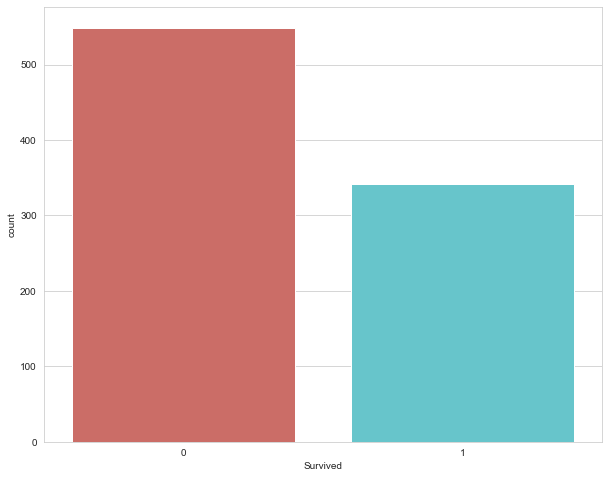

In [4]:
sb.countplot(x='Survived',data=titanic, palette='hls')

In [5]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
titanic_data = titanic.drop(['PassengerId','Name','Ticket','Cabin'], 1)
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


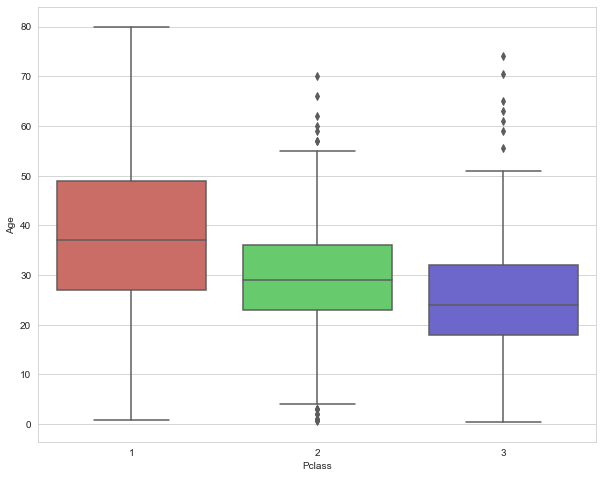

In [8]:
#Skapar saknade värden genom att använda hur ålder är relaterad till klass
sb.boxplot(x='Pclass', y='Age', data=titanic_data, palette='hls')

Vi kan se att ju yngre en passagerare är, desto troligare att denne åker i klass 3. Ju äldre en passagerare är, desto troligare att den reser i 1:a klass. Vi skriver därför en funktion som approximerar åldern på en passagerare baserat på vilken klassbiljett denne har. Medelåldern på 1:a klass är ungefär 37, 2:a klass är 29 och 3:dje klass är 24. Vår funktion hittar alla nullvärden och ersätter dem med medeåldern för en passagerare i den klass som denne reser. 

In [9]:
def age_approx(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

In [10]:
titanic_data['Age'] = titanic_data[['Age', 'Pclass']].apply(age_approx, axis=1)
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [11]:
#forfarande 2 null kvar, vi droppar dem eftersom vi gör bedömningen att de inte tillför alltför mycket till vår modell.  
titanic_data.dropna(inplace=True)
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

Konvertera categoriska variabler till dummyvariabler för att de ska fungera med vår modell som enbart kan ta nummer.Det gäller då kön och huruvida man gått på båten eller inte (embarked).


In [12]:
#skapa dummyvariabler för Sex
gender = pd.get_dummies(titanic_data['Sex'],drop_first=True)
gender.head()

,male
0,1
1,0
2,0
3,0
4,1


In [13]:
#skapa dummyvariabler för Embarked
embark_location = pd.get_dummies(titanic_data['Embarked'],drop_first=True)
embark_location.head()


,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [14]:
titanic_data.head()


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [15]:
#ta bort de ursprungliga kolumnerna för sex och embarked
titanic_data.drop(['Sex', 'Embarked'],axis=1,inplace=True)
titanic_data.head()


,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


In [16]:
#lägg till de nya dummykolumnerna
titanic_dmy = pd.concat([titanic_data,gender,embark_location],axis=1)
titanic_dmy.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


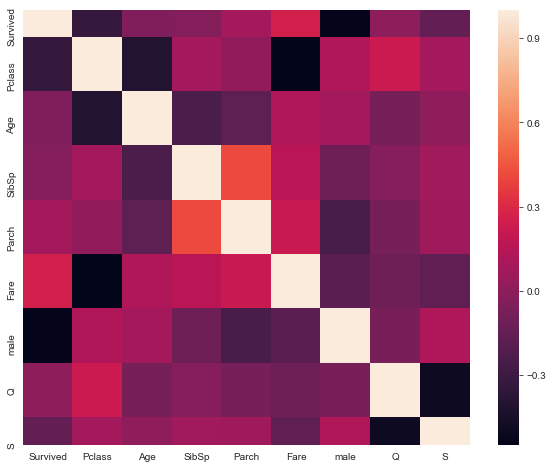

In [17]:
#kolla huruvida de olika variablerna för x är obereoende mha correlationsanalys
sb.heatmap(titanic_dmy.corr())  

In [18]:
#Fare and Pclass är inte oberoende så vi tar bort dem.
titanic_dmy.drop(['Fare', 'Pclass'],axis=1,inplace=True)
titanic_dmy.head()


,Survived,Age,SibSp,Parch,male,Q,S
0,0,22.0,1,0,1,0,1
1,1,38.0,1,0,0,0,0
2,1,26.0,0,0,0,0,1
3,1,35.0,1,0,0,0,1
4,0,35.0,0,0,1,0,1


In [19]:
#skapa vår matris för oberoende variabler (X), och vektorn för den beroende variabeln (y).
X = titanic_dmy.iloc[:,[1,2,3,4,5,6]]
y = titanic_dmy.iloc[:,0]
print (X)
print (y)


      Age  SibSp  Parch  male  Q  S
0    22.0      1      0     1  0  1
1    38.0      1      0     0  0  0
2    26.0      0      0     0  0  1
3    35.0      1      0     0  0  1
4    35.0      0      0     1  0  1
..    ...    ...    ...   ... .. ..
886  27.0      0      0     1  0  1
887  19.0      0      0     0  0  1
888  24.0      1      2     0  0  1
889  26.0      0      0     1  0  0
890  32.0      0      0     1  1  0

[889 rows x 6 columns]
0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 889, dtype: int64


In [20]:
#skapar test och träningsset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)
print("Our training data has {} rows".format(len(X_train)))
print("Our test data has {} rows".format(len(X_test)))

Our training data has 622 rows
Our test data has 267 rows


In [21]:
#Instansiera vår modell och träna den
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
#prediktera y med testdata
y_pred = LogReg.predict(X_test)

In [23]:
#skapa cunfusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[137,  27],
       [ 34,  69]])

Resultatet visar att 137 och 69 är korrekta och 34 och 27 inkorrekta prediktioner. 

Text(0.5, 510.88, 'Predicted label')

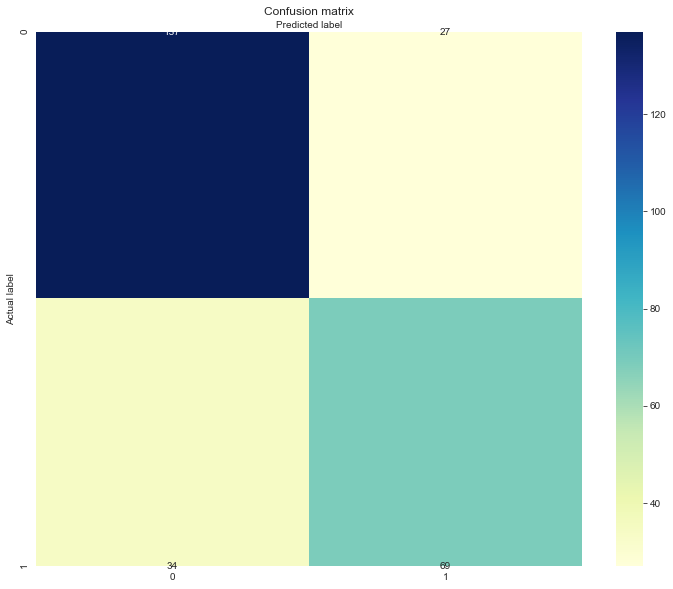

In [24]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sb.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [25]:
#skriv ut övriga kvalitetsparametrar
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       164
           1       0.72      0.67      0.69       103

    accuracy                           0.77       267
   macro avg       0.76      0.75      0.76       267
weighted avg       0.77      0.77      0.77       267

